In [23]:
### These are all libraries you will need throughout this exercise. 
### Be sure that this cell is compiled well.

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import dataclasses
import heapq
from typing import Any

# Welcome to the second graded exercise!

You are asked to fill in the code in a couple of cells throughout the exercise. Be sure that all the cells are compiling without any errors, otherwise you will get 0 for that cell. 

Before you finish, please make sure to 
* fill in your sciper number below;
* **upload only one file to Moodle: `graded_exercise_2.ipynb`**.

Good luck! :)

In [2]:
### FILL IN YOUR SCIPER NUMBER
sciper_number = 350968  # e.g. 123456

### The structure of this GE2 is the following:

100% of the grade is made up of three parts (23 points in total):

* Part 1: Region Growing Segmentation (7 points)
* Part 2: Min-Cut Segmentation (10 points)
* Part 3: Photometric Stereo Shape-from-Shading (6 points)

Before you start, we highly recommend to look through all the cells you will implement to get a better understanding what to expect. Once you start, read carefully all the documentation we provide and the notations we use in a current exercise.

Use your time wisely, it is very challenging to finish all the tasks in a short time you have.

### Good luck and show your best!

______

# Part 1: Region Growing (7 points)

In this section, you are asked to implement **a region growing algorithm for image segmentation**. For the detail of this method, we suggest you referring to the ***Segmentation*** lecture (slides 14-18).

We provide two examples: `image_river` and `image_dog`. For `image_river`, 3 seeds are provided and thus the image is expected to be segmented into 3 classes; for `image_dog`, the dog (foreground) should be segmented from  the background (2 classes). Feel free to use these images for debugging purposes.

First, in order to initialize a region around a seed and then grow it, one needs to find the neighbors of a center point. Therefore, you are asked to implement a **neighborhood searching function in Part 1.1**. Then we provide an implementation of a basic region growing method. You can check the segmentation results, using your neighborhood searching function. You may observe that some results are not satisfying using the basic method - in **Part 1.2 we then ask you to implement a more complicated region growing approach**.

### There are 2 exercises to implement (7 points in total):
* 1.1 `neighborhood` (1 point);
* 1.2 `region_growing_mean`(6 points).

*Note: both versions of region-growing algorithm take the function `neighborhood` that must also be implemented.
We assure you that if your implementation of the `neighborhood` function is incorrect, you still can get some points for `region_growing_mean`.*

In [3]:
import helpers_region_growing

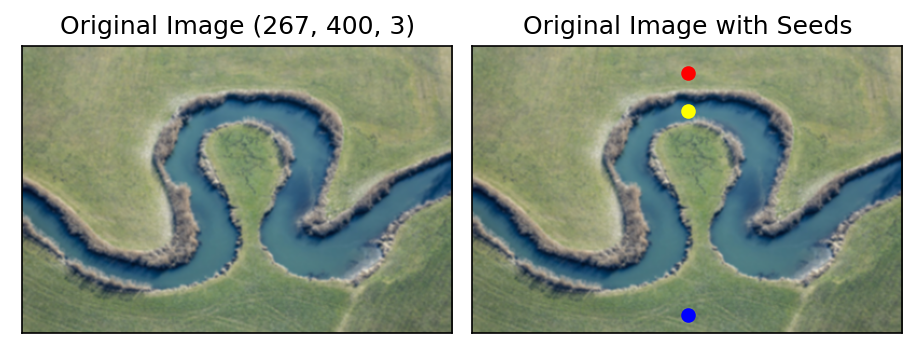

In [4]:
image_river = helpers_region_growing.load_img('presaved/river.jpg')
seeds_river = np.array([[200,25], [200, 60], [200,250]]) # N_seeds x 2 (x,y)
helpers_region_growing.display_init(image_river, seeds_river)

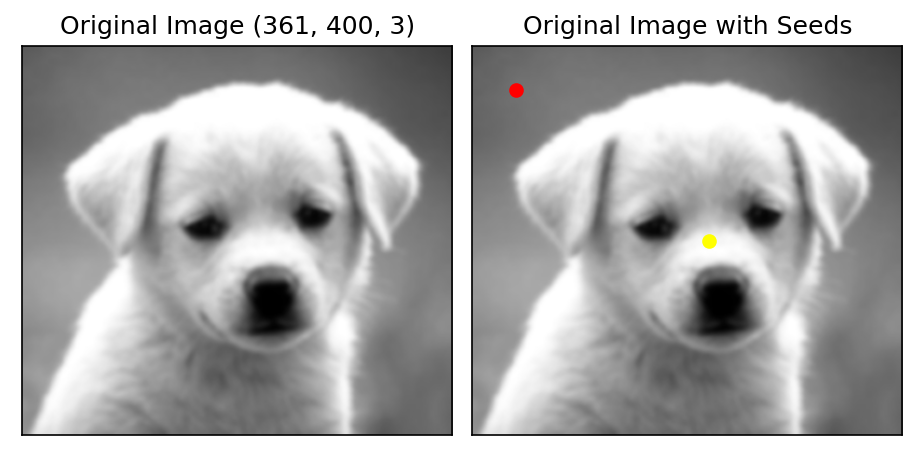

In [6]:
image_dog = helpers_region_growing.load_img('presaved/dog.jpg')
seeds_dog = np.array([[40, 40], [220, 180]]) # N_seeds x 2 (x,y)
helpers_region_growing.display_init(image_dog, seeds_dog)

# Part 1.1: Neighborhood Searching (1 point)

The following function should return a list of coordinates $(x', y')$ that are neighbors of a center location $(x, y)$ ($x$ for horizontal, $y$ for vertical axes). You are asked to get the eight neighbors of a center. Remember to **handle the edge cases**. For the convenience of grading, please store the neighbors in a list **clockwise** (from 1 to 8 as illustrated in the following image). 

<img src="presaved/neighbors.png" style="float: center; width: 20%;" />

In [26]:
def neighborhood(image, location):
    '''
    Inputs:
        image: image matrix, a 3-dimensional numpy array, size (H, W, 3) 
                Note that axes are height and width in this order.
        location: location of the center (x,y), tuple (int, int). 
                (x,y) is guaranteed to be a valid pixel. 
    Outputs:
        neighbors: a list of neighboring coordinates
    '''
    neighbors = []
    (H, W, _) = image.shape
    (x, y) = location
    for (i, j) in ((x-1, y-1), (x, y-1), (x+1, y-1), (x+1, y), (x+1, y+1), (x, y+1), (x-1, y+1), (x-1, y)):
        if 0 <= i < W and 0 <= j < H:
            neighbors.append((i, j))
    return neighbors

In [8]:
image_river.shape

(267, 400, 3)

Example: if `pixel = (100, 100)` has all 8 neighbors, then the correct output is:

`neighbors = [(99, 199), (100, 199), (101, 199), (101, 200), (101, 201), (100, 201), (99, 201), (99, 200)]`

In [9]:
print("mine: ", neighborhood(image_river, (100, 200)), "expected: ", [(99, 199), (100, 199), (101, 199), (101, 200), (101, 201), (100, 201), (99, 201), (99, 200)], sep="\n")

mine: 
[(99, 199), (100, 199), (101, 199), (101, 200), (101, 201), (100, 201), (99, 201), (99, 200)]
expected: 
[(99, 199), (100, 199), (101, 199), (101, 200), (101, 201), (100, 201), (99, 201), (99, 200)]


neighborhood(image, location)

_____________

## Basic Region Growing (no implementation required)

The following is the **basic implementation of the region-growing**, where the distance between a cluster and a candidate pixel is the difference between the color of the pixel and the cluster's seed.

First, you need to read the following code and understand how it works. The following exercise will ask you to make use of that code.
Second, you can execute the code using your `neighborhood` function and check the segmentation result. It may take a few seconds, so be patient.

Here are some explanations about the code:
1. We start with a seed for each blob (region) of pixels. 
2. We then iterate, at each step growing one of the blobs by one pixel - the one which is most similar to its neighboring cluster. This similarity is defined below by `distance_fn`.

We start by defining a priority queue: a class which stores objects and their associated keys in a sorted order, defined by key, and allows effectively retrieving the first of them (`pop`) and inserting new objects (`push`). You don't need to understand the implementation of `PriorityQueue`, just how it used in the next cell.

In [10]:
@dataclasses.dataclass(order=True, repr=True)
class Entry:
    '''
    A class storing the key and object, sorting only on the key value.
    '''
    key: float
    obj: Any = dataclasses.field(compare=False)
    
class PriorityQueue:
    def __init__(self):
        '''
        Initializes an empty priority queue.
        '''
        self._q = []
    
    def pop(self):
        '''
        Removes and returns the highest priority (lowest key value) object in the queue.
        '''
        if self.is_empty():
            raise ValueError("Popping from an empty PriorityQueue.")
        return heapq.heappop(self._q).obj
    
    def push(self, obj, key):
        '''
        Adds an arbitrary object `obj` with priority given by `key`. Lower key -> higher priority.
        Arguments:
            obj: any object you wish to store
            key: priority, a numerical value.
        '''
        if not isinstance(key, (float, int, np.float32, np.float64)):
            raise TypeError("Expected `key` to be numerical, got {}".format(type(key)))
            
        heapq.heappush(self._q, Entry(key, obj))
        
    def is_empty(self):
        '''
        Returns True if the queue is empty, False otherwise.
        '''
        return not bool(self._q)
    
    def __repr__(self):
        '''
        Provides a useful representation of the object when printed, useful for debugging.
        '''
        return repr(sorted(self._q, key=lambda entry: entry.key))
    
class Pixel:
    def __init__(self, blob_index, x, y):
        '''
        A helper struct representing a yet-to-be-assigned pixel. We keep its location
        and the index of the neighboring blob.
        blob_index: index to the cluster
        (x, y): pixel location
        '''
        self.blob_index = blob_index 
        self.x = x
        self.y = y
    
    def __repr__(self):
        return f'<Pixel id={self.blob_index}, x={self.x}, y={self.y}>'

In [11]:
def rgb_difference(candidate_color, blob_color):
    '''
    to be used as a distance function
    '''
    return ((candidate_color - blob_color) ** 2).sum()

### The main body of the region growing function   

In [12]:
def region_growing(image, distance_fn, seeds, neighborhood_func):
    '''
    Inputs:
        image: image matrix, a 3-dimensional numpy array, size (H, W, 3)
        distance_fn: distance function that estimates the similarity
        seeds: seed matrix, a 2-dimensional numpy array, size (N, 2) (x,y)
        neighborhood_func : previously implemented neighborhood function
    Outputs:
        segmentation result: a 2-dimensional numpy array, size (H, W). 
                                It has the predicted label at each pixel position.
    '''
    h, w, _3 = image.shape

    # -1 means the pixel has not been labeled yet
    segmentation = -np.ones((h, w))    
    
    # establish a queue to keep track of the order in which we consider pixels
    queue = PriorityQueue()
    
    # label the seed locations
    seeds_x, seeds_y = seeds[:, 0], seeds[:, 1]
    segmentation[seeds_y, seeds_x] = np.arange(seeds.shape[0])
    seed_colors = image[seeds_y, seeds_x]
    
    # Initialize blobs by adding seed neighbors to the queue.
    # Each blob includes a seed and its neighbors.
    for seed_ix, (seed_xy, seed_color) in enumerate(zip(seeds, seed_colors)):
        for (x, y) in neighborhood_func(image, seed_xy): # use your neighborhood function!
            # estimate the distance between neighbors and seeds
            distance = distance_fn(image[y, x], seed_color)
            
            # add neighbors to the queue which are sorted by the distance in ascending order
            queue.push(
                Pixel(blob_index=seed_ix, x=x, y=y),
                distance,
            )

    # main loop
    while not queue.is_empty():
        # pick up a pixel with the smallest distance at the current stage
        pixel = queue.pop()
        
        # skip if the pixel has already been labeled
        if segmentation[pixel.y, pixel.x] != -1:
            continue
        
        # label the pixel
        segmentation[pixel.y, pixel.x] = pixel.blob_index
        
        # add its neighbors to the queue
        for (x, y) in neighborhood(image, (pixel.x, pixel.y)): # use your neighborhood function!
            # estimate the distance between neighbors and seeds (fixed)
            distance = distance_fn(image[y, x], seed_colors[pixel.blob_index])
            
            # add neighbors to the queue which are sorted by the distance in ascending order
            queue.push(
                Pixel(blob_index=pixel.blob_index, x=x, y=y),
                distance,
            )
    
    assert not (segmentation == -1).any(), "segmentation incomplete"
    
    return segmentation

If `neighborhood` function is implemented correctly, then the following two cells must give ~97%-100% mIoU score (mean Intersection-over-Union):

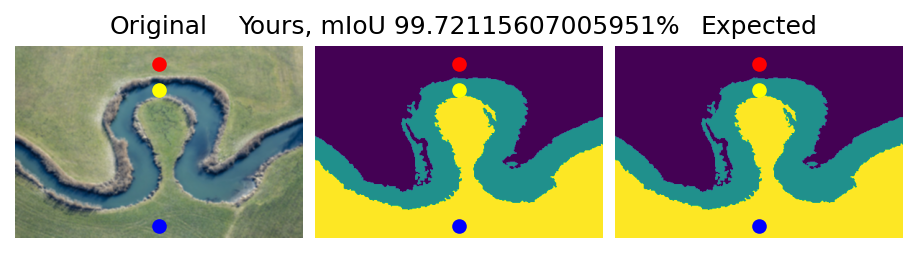

In [49]:
### River
res_river = region_growing(image_river, rgb_difference, seeds_river, neighborhood_func=neighborhood)
helpers_region_growing.test_seg(res_river, image_river, seeds_river, 'presaved/basic_river.npy')


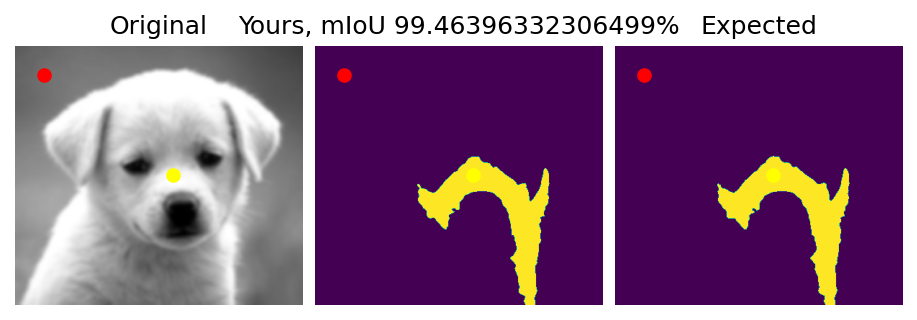

In [13]:
### Dog
res_dog = region_growing(image_dog, rgb_difference, seeds_dog, neighborhood_func=neighborhood)
helpers_region_growing.test_seg(res_dog, image_dog, seeds_dog, 'presaved/basic_dog_seed_1.npy')


You may observe that the segmentation result of the dog image is far from satisfying. Let us use a new group of seeds for this image.

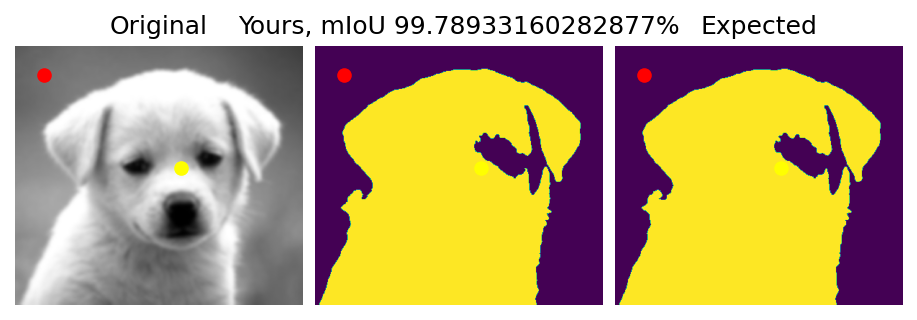

In [14]:
### new seeds for Dog
seeds_dog_new = np.array([[40, 40], [230, 170]])

res_dog = region_growing(image_dog, rgb_difference, seeds_dog_new, neighborhood_func=neighborhood)
helpers_region_growing.test_seg(res_dog, image_dog, seeds_dog_new, 'presaved/basic_dog_seed_2.npy')


If you implement the function correctly, you can observe that the segmentation result is much better after slightly changing the seed location.

___________

# Part 1.2: Region growing with mean cluster colors (6 points)

In the `region_growing` implementation, the distance function only depends on the color of a cluster's seed, which is fixed across updates. This means that as segmentation progresses, **the distance between the newly added pixels and the seed value can be very large** (this is exactly what happenned in the Dog case). As seen, this basic method is very sensitive to seed location. 

In this part you are asked to implement a more sophisticated version, where the distance is computed with respect to the **mean color of a blob**, rather than its seed. More formally, the distance $d$ is given as

\begin{align}
d(y, i)=\left|\left| g(y) - \frac{\sum_{y' \in A_i} g(y')}{|A_i|} \right|\right|_2^2,
\end{align}

where $A_i$ is the $i$-th blob (region), $|A_i|$ is the number of pixels in the $i$-th blob, and $g(y)$ represents the RGB value of pixel $y$ (a 3 dimensional vector). $||\cdot||_2^2$ means the squared $l2$ distance, that is the sum of square differences between the R, G and B components. Put together, instead of computing the distances between a proposal pixel and seed color, we will replace the latter with the current mean color of the blob.

In order to keep the runtime reasonable, rather than compute the mean at each step through the formula above, you should instead use an _online algorithm_, which in the case of computing means is quite simple. If $\mu_k$ is the mean color of a blob at step $k$, we can recover the sum of blob's pixel values as $\mu_k \cdot k$ and therefore
\begin{align}
\mu_{k+1} = \frac{\mu_k \cdot k + x}{k + 1},
\end{align}

where **$x$ is the newly added color value**. In order to solve this exercise, use the code from `region_growing` (copy-paste is welcome :) and integrate it with the mean-update logic described above.

_Note:_ if you think about it, there is an inconsistency in the solution we're asking you to implement - adding a new pixel to a blob changes its mean color and therefore all the distances, including those already inserted in the priority queue. This would mean that in principle we have to re-sort the entire set of candidates after each update, negating the benefits of a priority queue and greatly increasing the computational complexity of the algorithm. For the sake of efficiency, we will still use a priority queue: computer vision is often about sacrificing rigour in favor of runtime.

In [20]:
def region_growing_mean(image, distance_fn, seeds, neighborhood_func):
    '''
    Inputs:
        image: image matrix, a 3-dimensional numpy array, size (H, W, 3)
        distance_fn: distance function that estimates the similarity
        seeds: seed matrix, a 2-dimensional numpy array, size (N, 2) (x,y)
        neighborhood_func : previously implemented neighborhood function
    Outputs:
        segmentation result: a 2-dimensional numpy array, size (H, W)
                                It has the predicted label at each pixel position.
    '''
    h, w, _3 = image.shape

    # -1 means the pixel has not been labeled yet
    segmentation = -np.ones((h, w))    
    
    # establish a queue to keep track of the order in which we consider pixels
    queue = PriorityQueue()

    # to keep track of the mean color in each blob
    seeds_x, seeds_y = seeds[:, 0], seeds[:, 1]
    blob_means = image[seeds_y, seeds_x] # [N_seeds, 3]
    blob_counts = np.ones(seeds.shape[0]) # [N_seeds]
    
    # label the seed locations
    segmentation[seeds_y, seeds_x] = np.arange(seeds.shape[0]) # each seed loaction gets values 1, 2, 3 etc.
    
    # Initialize blobs by adding seed neighbors to the queue.
    # Each blob includes a seed and its neighbors.
    for seed_ix, (seed_xy, blob_mean) in enumerate(zip(seeds, blob_means)):
        for (x, y) in neighborhood_func(image, seed_xy): # use your neighborhood function!
            # estimate the distance between neighbors and seeds
            distance = distance_fn(image[y, x], blob_mean)
            
            # add neighbors to the queue which are sorted by the distance in ascending order
            queue.push(
                Pixel(blob_index=seed_ix, x=x, y=y),
                distance,
            )

    # main loop
    while not queue.is_empty():
        # pick up a pixel with the smallest distance at the current stage
        pixel = queue.pop()
        x, y = pixel.x, pixel.y
        i = pixel.blob_index
        
        # skip if the pixel has already been labeled
        if segmentation[y, x] != -1:
            continue
        
        # label the pixel
        segmentation[y, x] = i
        k = blob_counts[i]
        mu_k = blob_means[i]
        mu_k = ((mu_k * k) + image[y, x]) / (k + 1)
        blob_counts[i] += 1
        blob_means[i] = mu_k
        
        # add its neighbors to the queue
        for (x, y) in neighborhood(image, (pixel.x, pixel.y)): # use your neighborhood function!
            # estimate the distance between neighbors and seeds mean
            distance = distance_fn(image[y, x], blob_means[i])
            
            # add neighbors to the queue which are sorted by the distance in ascending order
            queue.push(
                Pixel(blob_index=i, x=x, y=y),
                distance,
            )
    
    assert not (segmentation == -1).any(), "segmentation incomplete"
    
    return segmentation

If `neighborhood` function is implemented correctly, then the following two cells must give ~97%-100% mIoU score (mean Intersection-over-Union):

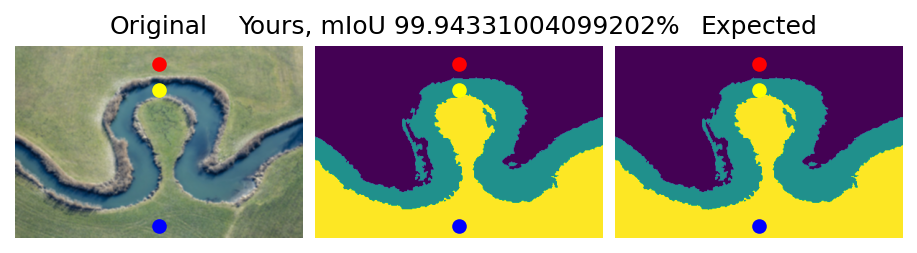

In [21]:
### River
res_river = region_growing_mean(image_river, rgb_difference, seeds_river, neighborhood_func=neighborhood)
helpers_region_growing.test_seg(res_river, image_river, seeds_river, 'presaved/mean_queue_river.npy')

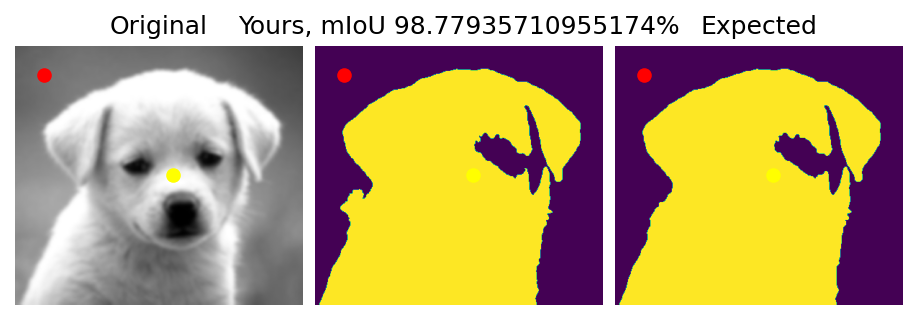

In [22]:
### Dog
res_dog = region_growing_mean(image_dog, rgb_difference, seeds_dog, neighborhood_func=neighborhood)
helpers_region_growing.test_seg(res_dog, image_dog, seeds_dog, 'presaved/mean_queue_dog_seed_1.npy')

Let us also segment the dog image using the new group of seeds.

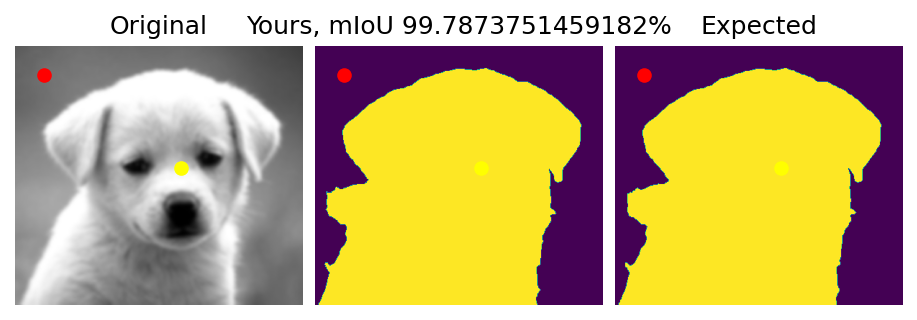

In [23]:
# new seeds for Dog
seeds_dog_new = np.array([[40, 40], [230, 170]])

res_dog = region_growing_mean(image_dog, rgb_difference, seeds_dog_new, neighborhood_func=neighborhood)
helpers_region_growing.test_seg(res_dog, image_dog, seeds_dog_new, 'presaved/mean_queue_dog_seed_2.npy')

_______

_______________

# Part 2: Graph-Cut for Segmentation (10 points)

In this problem we will perform segmentation on an image using **images as graphs**. 

To do so, first we will program the **Ford-Fulkerson algorithm**, which computes the maximum flow in a weighted directed graph. From the maximum flow, we will compute the minimum cut of the graph, following the Max-flow min-cut theorem (https://en.wikipedia.org/wiki/Max-flow_min-cut_theorem). Finally, we will code a function that maps an image into a graph and we will use **the minimum cut to segment the background and foreground** in these images.

You can find examples in the lecture on "Segmentation", slides 63-76.

**It is necessary to clarify how we will define a graph in this problem**. The most common way to represent graphs is by using $n x n$ "adjacency" matrices, where $n$ is the number of nodes. However, each pixel of an image would be mapped into a node, making the size of the matrix too large. Therefore, we will represent **a graph as a dictionary of dictionaries**. 

The key of the first dictionary will be a node $a$, and the key of the second one will be a node $b$, with the contained value being the edge ```a -> b```. 
Therefore, for any graph, **```graph[node a][node b] = value of edge (a -> b)```**, this is our convention. 

> _Note that in python dictionaries, key values must be immutable objects (strings, integers, tuples), you can feel free to use any_.

For instance, the resulting representation of the graph below would be:

```example_graph = {1: {2: 0.3, 3: 0.7}, 2: {1: 0.2, 3: 0.}, 3: {1: 0.}}```

<img src="presaved/toy_graph1.png" style="float: center; width: 40%;" />
    

First of all, you are asked to complete the functions used in the Ford-Fulkerson algorithm. It is a greedy algorithm that computes the maximum flow in a flow network, which is represented by a graph (https://en.wikipedia.org/wiki/Ford%E2%80%93Fulkerson_algorithm). 

### There are 4 exercises to implement (10 points in total):

Below you can find the main function that calls all the subroutines you will need to program:
* 2.1 `searching_algo_BFS` (3 points);
* 2.2 `find_path_flow` (2 points);
* 2.3 `update_graph` (2 points).

Later, we will apply Ford-Fulkerson algorithm to segment images.
To do this, you will implement the mapping from image array to the graph representation:
* 2.4 `image_to_graph` (3 points).

In [12]:
import helpers_min_cut

## Ford-Fulkerson algorithm (no implementation required)

In [13]:
def ford_fulkerson_min_cut(graph, s, t):
    '''
    This function computes the Min-Cut of a graph by first applying the Ford-Fulkerson algorithm.
    
    Parameters:
        graph: an input graph as a dictionary
        s: source node (valid key of the dict)
        t: sink node (valid key of the dict)
    
    Returns: 
        max_flow: a float representing the Max-Flow/Min-Cut of the graph
        min_cut: a dictionary that has as keys all the nodes of the graph and it has boolean values indicating
                 if the node is on the first or the second part of the segmentation
        
    '''
    max_flow = 0.
    parent = searching_algo_BFS(graph, s, t) # find some path from s to t

    while parent: # while path exists
        path_flow = find_path_flow(graph, s, t, parent) # find the value of the flow for a given path
        max_flow += path_flow # update maximum flow
        update_graph(graph, s, t, parent, path_flow) # reduce graph by the flow found earlier 
        parent = searching_algo_BFS(graph, s, t) # find a new path from s to t
        
    # at this moment no more paths from s to t exist
    # in ohter words, graph is reduced completely
    min_cut = find_min_cut(graph, s) # establish the minimum cut -> cut the graph in two parts
    return max_flow, min_cut

__________________

# Part 2.1: Finding a path with BFS (3 points)
The first function needed is the one that computes a BFS or Breadth-first search (https://en.wikipedia.org/wiki/Breadth-first_search).  The image below illustrates how the BFS algorithm expands along the nodes:

  <img src="presaved/BFS.jpg" style="float: center; width: 30%;"/>     

The ```searching_algo_BFS``` function takes the **graph, the source $s$ and the sink (target) $t$ nodes** as inputs. 
It then evaluates if there's a path that links $s$ with $t$ (all the edges in the path must be strictly positive) and if there is one, return it. 

- If there's **no** path, the function must return **None**. 

- If there's a path, the function must return a **dictionary `parent`**, which indicates the path that allows to go from $s$ to $t$. Later the path can be retrieved by recursively calling `parent`[$v$] with $v$ starting as $t$ (rolling back from $t$ to $s$). 

- if multiple paths exist in the graph, any path can be returned. The main point is that if in the graph a path from $s$ to $t$ exists, it **must** be found by the function.

- **Note:** The graph that ```searching_algo_BFS``` takes as input will be updated at each iteration by the ```update_graph``` function (see `ford_fulkerson_min_cut` above). Therefore, even though in the initial graph there may not be any edges with weight 0 (one normally would only consider as edges of a graph the ones with a strictly positive weight), in ```searching_algo_BFS``` we **must ensure that we only consider as candidates for a path the edges that have a positive weight** (the updated graph **will** contain edges with 0 weight). 

In [3]:
def searching_algo_BFS(graph, s, t):
    '''
    This function applies BFS to find if there's a path going from s to t. If there is, it returns a
    dictionary (parent) that contains the exact path from s to t.
    
    Parameters:
        graph: an input graph as a dictionary
        s: source node
        t: sink node
    
    Returns: 
        parent (dict): if it exists, a dictionary containing one path from s to t
        False (bool), if there's no path from s to t
        
    '''
    parent = {} # key - current node, value - its parent in the path
    visited = {v_: False for v_ in graph.keys()} # track visited nodes not to check them again
    visited[s] = True

    # BFS that returns the parent dictionary
    queue = [s]
    while queue:
        v = queue.pop(0)
        for w in graph[v].keys():
            if not visited[w] and graph[v][w] > 0:
                visited[w] = True
                queue.append(w)
                parent[w] = v
                if w == t:
                    return parent

We will test this function with the ```example_graph``` shown before. Let's consider 2 as the source node and 3 as the sink node. We can easily see that the only possible path is $2 \rightarrow 1 \rightarrow 3$, as shown in the image below. 

Therefore, the correct solution for ```searching_algo_BFS``` will return a dictionary like ```{1: 2, 3: 1}```.

<img src="presaved/toy_graph1_before.png" style="float: center; width: 40%;" />


In [4]:
example_graph = {1: {2: 0.3, 3: 0.7}, 2: {1: 0.2, 3: 0.}, 3: {1: 0.}}

source = 2
sink = 3
parent = searching_algo_BFS(example_graph, source, sink)

print(f'mine:     {parent} \nexpected: { {1: 2, 3: 1} }') # parent must be {1: 2, 3: 1}. It means that there is a path: 2 -> 1 -> 3
parent = {1: 2, 3: 1}

mine:     {1: 2, 3: 1} 
expected: {1: 2, 3: 1}


______________

# Part 2.2: Compute the flow value (2 points)

The second function is the ```find_path_flow```. It uses the `parent` dictionary computed before to go through the existing path from $s$ to $t$ and returns the maximum flow that can go through this path. The maximum flow from a given path will be equal to the maximum flow that can go through the smallest of the edges. It therefore suffices to return **the smallest edge weight in the path**. 

_Note:_ You can assume that there's always always a path between $s$ to $t$, i.e. the parent dictionary is not empty, since it is the condition in the while loop of the ```ford_fulkerson_min_cut``` function.

In [5]:
def find_path_flow(graph, s, t, parent):
    '''
    This function computes the maximum flow that can go from s to t through the path found by the BFS algorithm.
    The path is contained in the parent dictionary. 
    
    Parameters:
        graph: an input graph as a dictionary
        s: source node (valid key of the dict)
        t: sink node (valid key of the dict)
        parent: a dictionary containing the path from s to t found by the BFS algorithm
    
    Returns: 
        pathflow: a float representing the maximum flow that can go from s to t through parent
    '''
    
    path_flow = float("Inf")
    v = t
    while v != s:
        w = parent[v]
        path_flow = min(path_flow, graph[w][v])
        v = w
    return path_flow

We will now test the ```find_path_flow``` function again with the ```example_graph``` on the same path $2\rightarrow1\rightarrow3$. 

The correct solution returns $0.2$, since it is the minimum value between the edges in the path found by ```searching_algo_BFS```. It corresponds to the value of $2\rightarrow1$, as we can see in the image below:

<img src="presaved/toy_graph1_path_flow.png" style="float: center; width: 40%;" />


In [6]:
path_flow = find_path_flow(example_graph, source, sink, parent)
print(f'path flow: {path_flow}') # must be 0.2

path flow: 0.2


__________________

# Part 2.3: Update the graph (2 points)

The third function you need to complete is the ```update_graph```. It updates the edges of the path in the graph representation. The intuition here is that, once we have taken into account the flow that goes through a specific path, we must update the graph so that this path is not a feasible path anymore, since we have already considered it. The updated graph is called **reduced graph**.

_Note:_ Be careful that any flow can be inversed, thus when a flow is added to an edge, the capacity of the reverse edge should also be updated. You can assume that the reverse edge is present in the graph. 

To better illustrate this, find below the updated version of the ```example_graph```. We have seen before that there is a flow of $0.2$ in the path $2\rightarrow1\rightarrow3$. 
Therefore, ```update_graph```  must update the graph by subtracting $0.2$ from the capacity of $2\rightarrow1$ and $1\rightarrow3$. 
Moreover, it is also necessary to **add** this flow to the capacity of the edge $3\rightarrow1$ and $1\rightarrow2$. 
This is needed to preserve the properties of the flow network so that the algorithm achieves the optimal solution.

<img src="presaved/toy_graph_before_after.png" style="float: center; width: 70%;" />

In [7]:
def update_graph(graph, s, t, parent, path_flow) -> None:
    '''
    This function updates the input graph: it updates the edges of the path in the graph representation.
    In a nutshell, this function subtracts the path_flow from all the edges of the path in parent. The reversed
    edges are also updated.
    Note: do not forget to compensate for reverse path!
    
    Parameters:
        graph: an input graph as a dictionary
        s: source node
        t: sink node
        parent: a dictionary containing the path from s to t found by the BFS algorithm
        path_flow: a float representing the maximum flow that can go from s to t through parent

    Returns: 
        None: this function doesn't return any value
    '''
    
    v = t
    while v != s:
        w = parent[v]
        graph[w][v] -= path_flow
        graph[v][w] += path_flow
        v = w

_Note:_ Numerical errors could occur and will NOT be penalized.

For the path found above, our solution gave us the following reduced graph:

`{1: {2: 0.5, 3: 0.49999999999999994}, 2: {1: 0.0, 3: 0.0}, 3: {1: 0.2}} `

In [8]:
update_graph(example_graph, source, sink, parent, path_flow)
print(f'updated graph: {example_graph}')

updated graph: {1: {2: 0.5, 3: 0.49999999999999994}, 2: {1: 0.0, 3: 0.0}, 3: {1: 0.2}}


______

## Find the min-cut (no implementation required)
Finally, once we have found the maximum flow in the graph with the Ford-Fulkerson algorithm, we can now compute the minimum cut. We define the minimum cut value as the minimum sum of weights of edges that, if removed from the graph, would divide the graph in two sets. Moreover, there's a property that says that the maximum flow value in a graph is equal to its minimum cut value.

We can find the minimum cut using the **reduced graph**. We know by construction that, since the Ford-Fulkerson algorithm has converged, there's no path between any of the source and sink nodes (the while condition in the code has returned `None` in the last iteration for the BFS function). 
Therefore, in order to see which nodes belong to the first partition of the graph and the nodes that belong to the second partition of the graph, we can simply calculate the connected components to any of the source nodes. 

One efficient way of calculating the connected components of a graph is the DFS or Depth-first search algorithm (https://en.wikipedia.org/wiki/Depth-first_search). Note that this algorithm is different from the BFS algorithm explained before. In a DFS, the graph is traversed in a depthward motion, i.e. once a node is visited, in the following iteration one of its child nodes is visited and in the following one it is the child of the child. In contrast, in a BFS, the graph is traversed in a breadthward motion, i.e. all the "child" nodes of a parent node are visited before visiting the child of any of the child nodes. For a better understanding of the difference between BFS and DFS see the image below:

<img src="presaved/BFS-and-DFS.png" style="float: center; width: 60%;" />

In [9]:
def dfs(graph, s, visited):
    '''
    This function applies recuersively DFS to a graph starting at node s. 
    
    Parameters:
        graph: an input graph as a dictionary
        s: source node
        visited: a dictionary with boolean values that tracks if a given key node has been visited
    
    Returns: 
        visited: a dictionary with boolean values that tracks if a given key node has been visited
        
    '''
    
    visited[s] = True
    for i in graph[s]:
        if graph[s][i] > 0 and not visited[i]:
            dfs(graph, i, visited)
    return visited

In [10]:
def find_min_cut(graph, s):
    '''
    This function uses the dfs function to find the connected components of s in the graph. 
    
    Parameters:
        graph: an input graph as a dictionary
        s: source node
    
    Returns: 
        visited: a dictionary with boolean values that tracks if a given key node has been visited
        
    '''
        
    visited = {v: False for v in graph.keys()}
    visited = dfs(graph, s, visited)
    return visited

This first toy example should return a maximum flow of 3, and a trivial segmentation of the graph

In [14]:
# Trivial example, graph: 1 <-(3)-> 2
graph = {1: {2: 3}, 2: {1: 3}}
source = 1
sink = 2

max_flow, graph_seg = ford_fulkerson_min_cut(graph, source, sink)
print(f"Max-Flow/Min-Cut value: {max_flow}")
print(graph_seg)

Max-Flow/Min-Cut value: 3.0
{1: True, 2: False}


The second toy example is the ```example_graph```, the one that has been used for the testing of the previous functions. As we saw before, after one iteration of the BFS, the source 2 had all its edges equal to 0. Therefore the source node will belong to one cut and the node 1 and the sink 3 to the other cut.

In [15]:
graph = {1: {2: 0.3, 3: 0.7}, 2: {1: 0.2, 3: 0.}, 3: {1: 0.}}
source = 2
sink = 3

max_flow, graph_seg = ford_fulkerson_min_cut(graph, source, sink)
print(f"Max-Flow/Min-Cut value: {max_flow}")
print(graph_seg)

Max-Flow/Min-Cut value: 0.2
{1: False, 2: True, 3: False}


The third example is the one in Wikipedia, represented by the image below. The maximum flow and therefore the minimum cut in the image is 5. The minimum cut separes the graph in two, the first of them containing the nodes s (the source) and p.

<img src="presaved/max_flow_ex.png" style="float: center; width: 40%;" />

In [16]:
### Note: one can use strings as names of the nodes

graph = {
    's': {'o':3, 'p':3}, 
    'o': {'p':2, 'q':3, 's':0}, 
    'p': {'r':2, 'o':0, 's':0}, 
    'q': {'r':4, 't':2, 'o':0}, 
    'r': {'t':3, 'q':0, 'p':0}, 
    't': {'r':0, 'q':0}
}

source = 's'
sink = 't'

max_flow, graph_seg = ford_fulkerson_min_cut(graph, source, sink)
print(f"Max-Flow/Min-Cut value: {max_flow}")
print(graph_seg)

Max-Flow/Min-Cut value: 5.0
{'s': True, 'o': False, 'p': True, 'q': False, 'r': False, 't': False}


_____________________________

# Part 2.4 Transforming an image into a graph (3 points)

Finally, in this last part we will work with images. You must implement a function ```image_to_graph``` that maps an image to a graph (similarly to what is done in slide 63 in "Segmentation"). 

We will represent the graph in the same way as before, **dictionary of dictionaries**, while here each node corresponds to the pixel coordinates and the weight of the edge between two nodes must be proportional to the similarity between the two pixels. More precisely, the edge weight between pixels $p$ and $q$ is defined as:

$$100 · exp\left(\frac{-(I_p-I_q)^2}{2\sigma^2}\right)$$

Here is its implementation for you:

In [40]:
def compute_sim(pix1, pix2, sigma=30):
    '''
    This function computes the similarity between two pixels using the previous formula
    
    Parameters:
        pix1: a float representing the first pixels' brightness
        pix2: a float representing the second pixels' brightness
        sigma: a parameter used in the formula
    
    Returns: 
        similarity: a float representing the similarity between pix1 and pix2
    '''

    # the bigger the number,  the more similar two pixels are
    similarity = 100 * np.exp(-((int(pix1)-int(pix2))**2)/(2*sigma**2))
    return similarity

It is important to note that now we have a bidirectional graph, i.e. the edge between $p$ and $q$ is the same as the edge between $q$ and $p$. Additionally, we will consider that the adjacent pixels are the only ones having an edge connecting them, so that the degree of a node cannot exceed 4 (see slide 63).

_Note:_ One can use tuples of two integers to represent the pixel coordinates as a key for python's dicts. For example, `graph[(1,5)][(2,5)]` would mean an edge from the pixel `(1,5)` to `(2,5)`.

In [52]:
def image_to_graph(img):
    '''
    This function maps the image to a graph-like structure.
    
    Hint: You need to pay attention to the border pixels. If you are computing the edge of a border pixel, 
    then you need to check only for the valid neighbouring pixels. 
    
    Parameters:
        img: input image that will be mapped to a graph
    
    Returns: 
        graph: the mapped version of the image as a dictionary of dictionaries
        
    '''
    
    graph = {}
    H, W = img.shape
    for x in range(W):
        for y in range(H):
            graph[(x, y)] = {}
            for (i, j) in neighborhood(img[:, :, np.newaxis], (x, y)):
                graph[(x, y)][(i, j)] = compute_sim(img[y, x], img[j, i])
                
    return graph

______

Finally, we will check our solution with some sample images. The function ```plot_segmentation``` takes an image as input, as well as the source and sink nodes (which have to be manually defined by the user), and plots the segmented image. Furthermore, we will explain some advantages and disadvantages of this algorithm compared to binary thresholding, one of the simplest segmentation algorithms.

In [53]:
def plot_segmentation(img, s, t):
    '''
    This function segments an original image by finding the Min-Cut with s and t as source and sink nodes. 
    It then plots the original image, the binary mask of the segmentation and a superposition of these two.
    It also plots the points used as source and sink nodes. 
    
    Parameters:
        img: input image
        s: a list containing the source nodes
        t: a list containing the sink nodes
    
    Returns: 
        None: this function doesn't return any value
        
    '''
    graph = image_to_graph(img)
    
    helpers_min_cut.add_source_and_sink(graph, s, t)
    source = 'source'
    sink = 'sink'
    
    max_flow, graph_seg = ford_fulkerson_min_cut(graph, source, sink)
    print(f"Max-Flow/Min-Cut: {max_flow}")
    
    bin_img = helpers_min_cut.graph_to_binary_image(graph_seg, img.shape)
    helpers_min_cut.plotting_segmentation(img, bin_img*255, s, t)

The first example consists of an image of the popular **MNIST** dataset. In this case, we have defined one source node (background) and one sink node (foreground). We can see that the segmentation it does is pretty accurate, but we would get a similar result using simple thresholding:

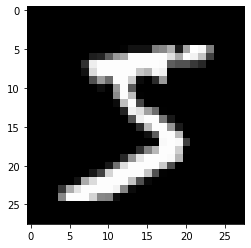

In [54]:
img = cv2.imread('presaved/five.png', 0)
plt.imshow(img, cmap='gray');

Max-Flow/Min-Cut: 799.9999999999998


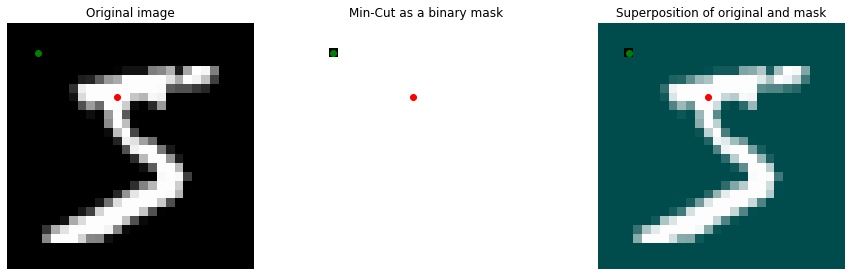

In [55]:
s = [(3,3)]
t = [(8,12)]
plot_segmentation(img, s, t)

The second example relies once again on an image of the **MNIST** dataset. However, in this case, it is an image of the number 0. Since it has a hole in it, the algorithm doesn't perform well, since the hole is also considered as part of the number. This is a case where simple thresholding would perform better:

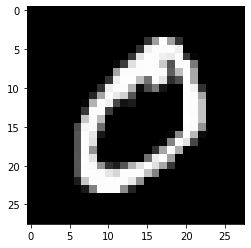

In [47]:
img = cv2.imread('presaved/zero.png', 0)
plt.imshow(img, cmap='gray')

Max-Flow/Min-Cut: 11.77960160577308


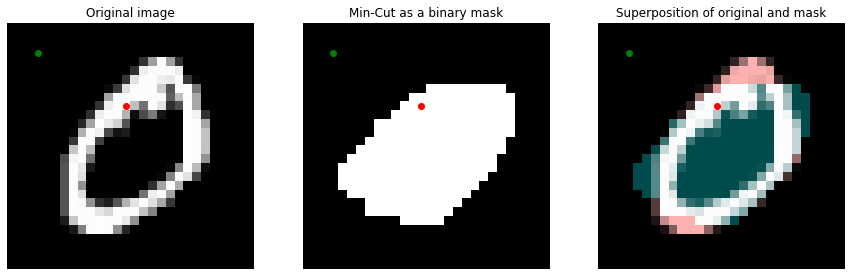

In [48]:
s = [(3,3)]
t = [(9,13)]
plot_segmentation(img, s, t)

Finally, we show a more complex image of a puppy. Note that for the algorithm to accurately perform the segmentation, **we must provide a higher number of source and sink nodes**. However, with a proper interface, this can be done by the user fairly quickly, and in this case simple thresholding would not be an option. Therefore, this is an example where the Ford-Fulkerson algorithm would be rather a good option for the segmentation task.

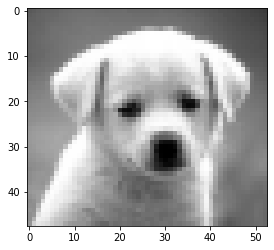

In [49]:
img = cv2.imread('presaved/dog16.png', 0)
plt.imshow(img, cmap='gray');

In [51]:
s = [(3,3), (2,10), (3,50), (2,30), (12,2), (20,2), (15,50), (20,50),\
    (25,48), (23,50), (25,5), (25,2), (35,5), (40,2), (40,45)]
t = [(8,30), (9,25), (10, 20), (9,35), (15,45),(25,40), (16,7), (26,13),\
    (31,10), (40,6)]
plot_segmentation(img, s, t)

KeyError: (3, 50)

However, when using a more reduced number of source and sink nodes, the segmentation may not be as good, we can see it in the image below. 

This showcases the main drawback of this algorithm: 
* to make it work, user must select the source and sink nodes manually; 
* to make it work reliably sometimes user needs to select a lot of them.

Max-Flow/Min-Cut: 2228.3666113689465


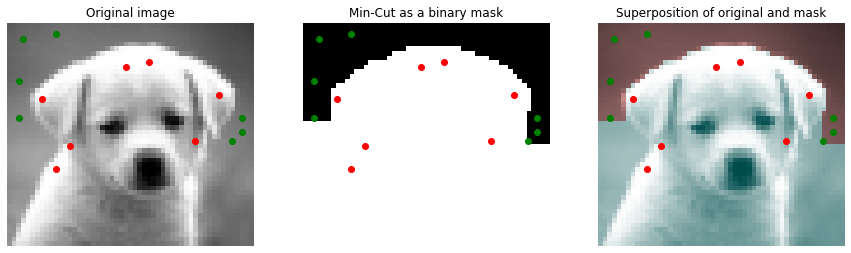

In [39]:
s = [(3,3), (2,10), (12,2), (20,2), (20,50), (25,48), (23,50)]
t = [(8,30), (9,25), (15,45),(25,40), (16,7), (26,13), (31,10)]
plot_segmentation(img, s, t)

______

_______

# Part 3: Photometric Stereo (6 points)

As you have seen in the course, particularly in the **Shape from Shading** lecture (slides 53 onwards), given multiple images of the same surface under different known lighting conditions (at least 3), it is possible to recover the surface shape by estimating **the albedo and the surface normals**.

Suppose we have $N$ images $I_1, I_2,..., I_N$ of the same surface, which are filmed under $N$ lighting conditions. The corresponding light directions are $L_1, L_2,..., L_N$. 
According to the Lambertian model:
\begin{align}
I = \alpha(L\cdot n)=L\cdot M,
\end{align}
where $\alpha$ and $n$ represent the albedo and normal of the surface respectively and $M$ is an unknown vector representing the product of albedo and surface normals. 
One can have the following equations based on the given images:
\begin{align}
\begin{bmatrix}
I_1 \\
\vdots \\
I_N 
\end{bmatrix}=
\begin{bmatrix}
L_1 \\
\vdots \\
L_N 
\end{bmatrix}
M.
\end{align}

Therefore, in this exercise, you are asked **to implement a function which can recover the albedo and the normals by solving the above equations.** Note that we recover $M$ first before recovering each component individually. 

### There are 3 exercises to implement (6 points in total):

* 3.1 `flatten` (1 point);
* 3.2 `least_square` (2 points);
* 3.3 `get_albedo_and_normal` (3 points).

Let's start by looking at an example input image. The example only contains **images under 3 different lighting sources**. 
But your implementation must be able to handle $N (>=3)$ images. 

_Note: the images $I$ and the lights $L$ are always numpy arrays with the size of $(W, H, N)$ and $(N, 3)$ respectively._

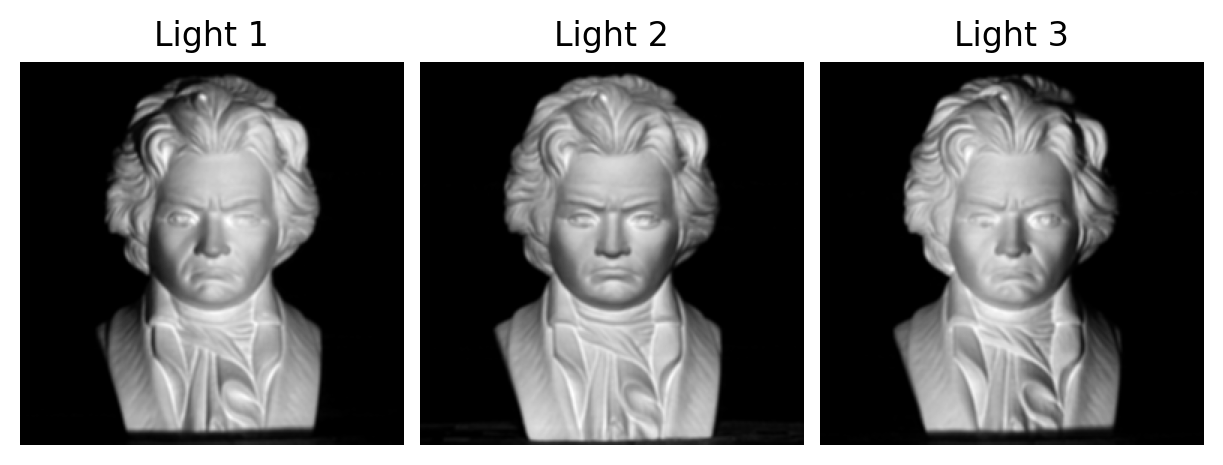

In [5]:
import helpers_photom_stereo
images = np.load('presaved/I_blur.npy').astype(float) # images: (256 x 256 x 3)
lights = np.load('presaved/L.npy').astype(float) # lights: (3 x 3)

helpers_photom_stereo.display(images)

_________________________________________________________________________________

# Part 3.1 Flattening (1 point)

Given $N$ images with size $(W, H)$, write a function to flatten and stack them into a numpy array with size $(N, W*H)$. This step is to reshape the images to have the desired matrix form as 
\begin{align}
I=
\begin{bmatrix}
I_1 \\
\vdots \\
I_N 
\end{bmatrix},
\end{align}
which will be easy for us to use when solving the equations mentioned at the beginning.

In [6]:
def flatten(images):
    '''
    Inputs:
        images: image matrix, a 3-dimensional numpy array, size (W, H, N)
    Outputs:
        images_flatten: a 2-dimensional numpy array, size (N, W*H)
    '''
    (W, H, N) = images.shape
    return np.rollaxis(images,2).reshape((N, W*H))

In [7]:
images_flatten = flatten(images) # output must be [3, 256*256]
helpers_photom_stereo.check_flatten(images_flatten)

The expected size is:  (3, 65536)  Yours is:  (3, 65536)
Max error: 0.00


_________________________________________________________________________________

# Part 3.2: Solve for $M$ using least squares (2 points)

Now we have the image matrix $I$ and light matrix $L$, let's solve the following equation to obtain $M$:
\begin{align}
I =L\cdot M
\end{align}

The straighforward solution would be to compute 
\begin{align}
M =L^{-1}\cdot I
\end{align}

However, this solution is not practical for a very simple reason. If the number of images we have is larger than 3, then $L$ is not always a square matrix, thus $L$ is not invertible. We can not directly compute the inverse of $L$ to obtain the solution of $M$. 

So, if we managed to find an invertible square matrix (e.g. $f(L)$) instead of $L$, we can simply apply the previous equation and solve for $M$ in a closed form. For instance, if we multiplied both sides of the equation by $L^{T}$, the equation would change to: 

\begin{align}
L^T I = L^T L \cdot M
\end{align}

Accordingly, we can solve now for $M$ since the term $L^TL$ has become now a square invertible matrix. 

In this task, you need to write a function that applies the `least_squares` method for solving $M$. 


Hint: you can use `np.linalg.inv` function.

In [8]:
def least_square(I, L):
    '''
    Inputs:
        I: image matrix, a 2-dimensional numpy array, size (N, W*H)
        L: light matrix, a 2-dimensional numpy array, size (N, 3)
    Outputs:
        M: a 2-dimensional numpy array, size (3, W*H)
    '''
    return np.linalg.inv(L.T @ L) @ L.T @ I

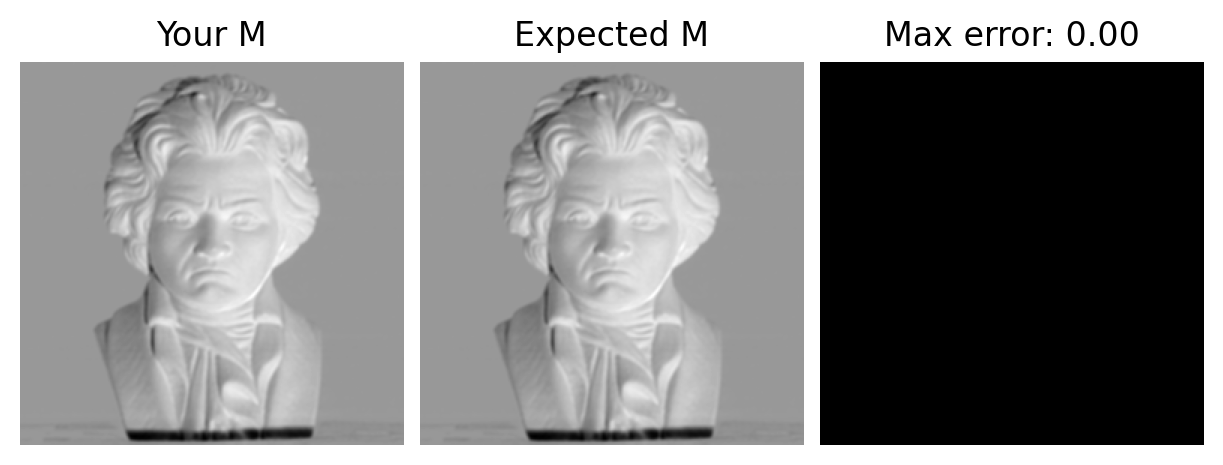

In [9]:
images_flatten_test = np.load('presaved/I_flatten.npy') # for tests
M = least_square(images_flatten_test, lights)
helpers_photom_stereo.show_M(M)

_________________________________________________________________________________

# Part 3.3: Compute albedo and normals (3 points)

Once we have the solution of $M$, the albedo $\alpha$ and the normal $n$ can be recovered by:
\begin{align}
\alpha= ||M||, ~ n=\frac{M}{||M||}.
\end{align}

Write a function to compute the albedo and the normals from matrix $M$. 
- For $i$ where $||M[:, i]||=0$, use `eps` as the value of $||M[:, i]||$.

In [10]:
def get_albedo_and_normal(M, eps=1e-4):
    '''
    Input:
        M: the solution of 'least_square', a 2-dimensional numpy array, size (3, W*H)
        eps: do not change this value!!! The default value to take care of 'division by zero'.
    Output:
        albedo: the recovered albedo, a 1-dimensional numpy array, size (W*H,)
        normal: the recovered normal, a 2-dimensional numpy array, size (3, W*H)
    '''
    albedo = np.linalg.norm(M, axis=0)
    albedo[albedo < eps] = eps
    normal = M / albedo
    return albedo, normal

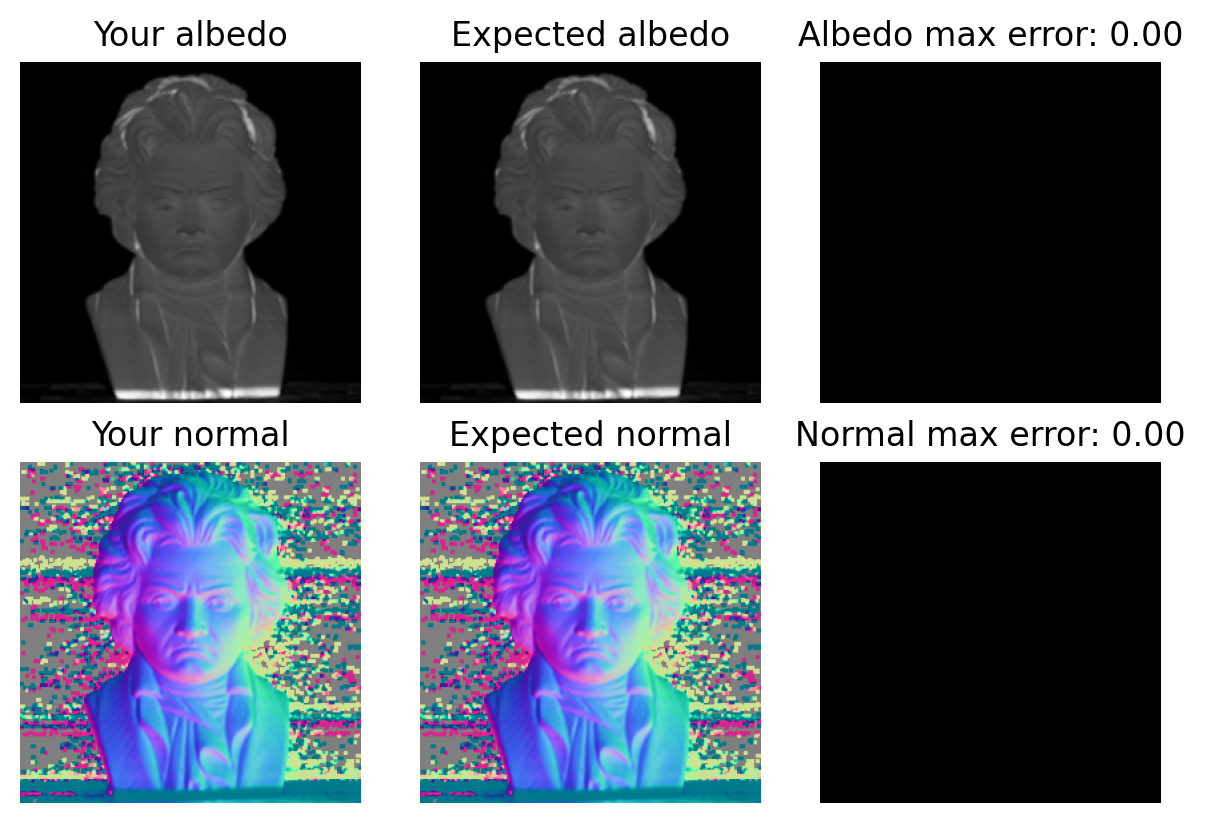

In [11]:
M_test = np.load('presaved/M.npy') # for tests
albedo, normal = get_albedo_and_normal(M_test)
helpers_photom_stereo.show_albedo_normal(albedo, normal)

_________________________________________________________________________________

# Clean Normal Map (No Implementation Required)
You may observe that there is some noise showing at the background of your normal map. Since these background noise usually happens when the albedo value is small, a simple solution is to generate a mask based on the albedo and mask noise out for a clean normal map.

There is a function `get_mask` in helpers_photom_stereo.py, which is used to generate the desired mask. Given an input array, it outputs a mask that satisfies:
- $mask[i] = 0$ if $array[i]<=threshold$;
- $mask[i] = 1$ if $array[i]>threshold$.

You can call `show_final_results` (where `get_mask` is called) as below to get the clean normal map. Try to replace `albedo_test` and `normal_test` with your albedo and normal obtained in Exercise 3 to see how it looks.

albedo array shape: (65536,), normals array shape: (3, 65536)


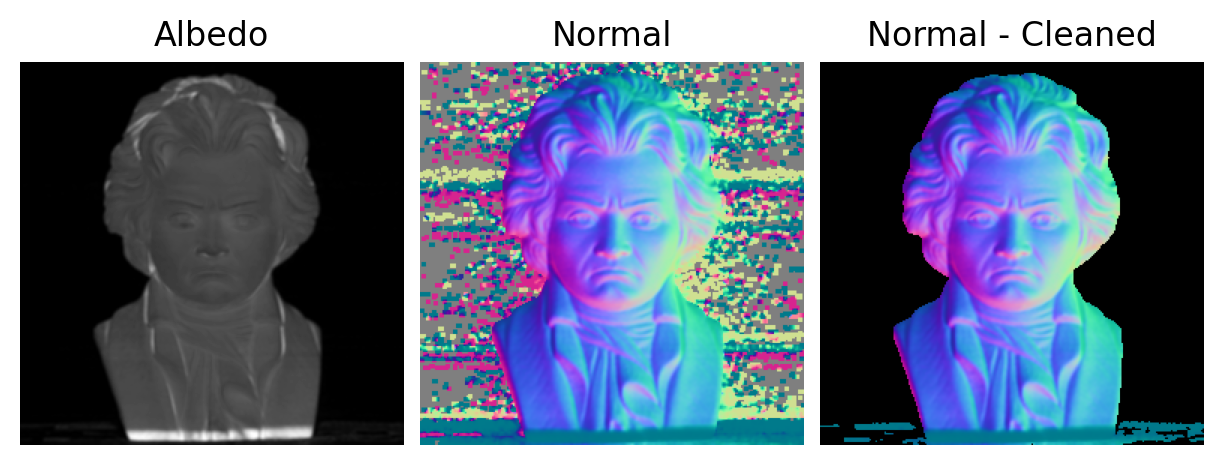

In [12]:
albedo_test = np.load('presaved/albedo.npy') # for tests
normal_test = np.load('presaved/normal.npy') # for tests
print(f'albedo array shape: {albedo_test.shape}, normals array shape: {normal_test.shape}')

helpers_photom_stereo.show_final_results(albedo_test, normal_test)

_________________________________________________________________________________